In [1]:
import numpy as np
import pydicom
import nibabel as nib
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from time import perf_counter
from scipy.stats import wilcoxon
from scipy.ndimage.measurements import label
from matplotlib.collections import LineCollection
from scipy import ndimage
from sklearn.metrics import roc_curve, auc
from statsmodels.stats.multitest import fdrcorrection

C:\Users\oonar\AppData\Local\Temp\ipykernel_28848\3496204169.py:12: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import label


In [2]:
def preprocess(img):

    img=cv2.resize(img,(128,128))
    if np.max(img)>np.min(img):
        img=(img-np.min(img))/(np.max(img)-np.min(img))
    else:
        img=np.zeros((128,128))
    return img.astype('float16')

def fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k):

    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    patientIndexes_test=[]
    patientIndexes_train=[]

    for i in range(len(patientIndexes)):
        if patientIndexes[i] % 5==k:
            x_test.append(slices[i])
            y_test.append(sliceIndexes[i])
            patientIndexes_test.append(patientIndexes[i])
        else:
            x_train.append(slices[i])
            y_train.append(sliceIndexes[i])
            patientIndexes_train.append(patientIndexes[i])

    x_train=np.array(x_train).astype('float16')
    y_train=np.array(y_train) 
    x_test=np.array(x_test).astype('float16')
    y_test=np.array(y_test)

    return(x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test)

def predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs):

    if len(x_train[0].shape)==3:
        input_shape=x_train[0].shape
    else:
        input_shape=(128,128,1)

    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=input_shape),
                                    tf.keras.layers.Conv2D(16, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
    ] 
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    history=model.fit(x=x_train,y=y_train,epochs=numberOfEpochs,shuffle=True)
    predictions=model.predict(x_test)[:,0]
    trainPreds=model.predict(x_train)[:,0]
    plt.plot(range(len(history.history['loss'])),history.history['loss'],color='blue')

    return([predictions,trainPreds])

def mobilenet_block(x,filters,strides):
    
    x = tf.keras.layers.DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    return x

def predict_mobilenet(x_train,y_train,x_test,numberOfEpochs):

    if len(x_train[0].shape)==3:
        input_shape=x_train[0].shape
    else:
        input_shape=(128,128,1)

    input = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    # main part of the model
    x = mobilenet_block(x, filters = 64, strides = 1)
    x = mobilenet_block(x, filters = 128, strides = 2)
    x = mobilenet_block(x, filters = 128, strides = 1)
    x = mobilenet_block(x, filters = 256, strides = 2)
    x = mobilenet_block(x, filters = 256, strides = 1)
    x = mobilenet_block(x, filters = 512, strides = 2) 
    x = tf.keras.layers.AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
    x = tf.keras.layers.GlobalAveragePooling2D (data_format='channels_first')(x)   
    output = tf.keras.layers.Dense (units = 1, activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    history=model.fit(x=x_train,y=y_train,epochs=numberOfEpochs,shuffle=True)
    predictions=model.predict(x_test)[:,0]
    trainPreds=model.predict(x_train)[:,0]
    plt.plot(range(len(history.history['loss'])),history.history['loss'],color='blue')

    return([predictions,trainPreds])

def evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train):

    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    J_stats = tpr - fpr
    youden = thresholds[np.argmax(J_stats)]

    acc_list=[]
    sen_list=[]
    spe_list=[]
    pre_list=[]
    auc_list=[]
    
    for i in range(len(np.unique(patientIndexes_test))):
        subPredictions=np.array(predictions[patientIndexes_test==np.unique(patientIndexes_test)[i]],dtype=float)
        subLabels=np.array(y_test[patientIndexes_test==np.unique(patientIndexes_test)[i]],dtype=int)
        negLabels=-subLabels+1
        TP = np.sum(subLabels[subPredictions>=youden])
        FN = np.sum(subLabels[subPredictions<youden])
        FP = np.sum(negLabels[subPredictions>=youden])
        TN = np.sum(negLabels[subPredictions<youden])
        if TP+TN==0:
            acc=0
        else:
           acc = (TP+TN)/(TP+TN+FN+FP) 
        if TP==0:
            sen=0
            pre=0
        else:
            sen = TP/(TP+FN)
            pre = TP/(TP+FP)
        if TN==0:
            spe=0
        else:
            spe = TN/(TN+FP)
        acc_list.append(acc)
        spe_list.append(spe)
        if TP+FN!=0:
            sen_list.append(sen)
            pre_list.append(pre)
            fpr, tpr, thresholds = roc_curve(subLabels,subPredictions,drop_intermediate=False)
            auc1=auc(fpr, tpr)
            auc_list.append(auc1)
    return(acc_list,sen_list,spe_list,pre_list,auc_list)

def postProcess(predictions,patientIndexes_test):

    predictions_1=[]
    for i in range(len(predictions)):
        current=predictions[i]
        if i>0:
            if patientIndexes_test[i-1]==patientIndexes_test[i]:
                prev=predictions[i-1]
            else:
                prev=0
        else:
            prev=0
        if i<len(predictions)-1:
            if patientIndexes_test[i+1]==patientIndexes_test[i]:
                next=predictions[i+1]
            else:
                next=0
        else:
            next=0
        predictions_1.append(np.mean([prev,current,next]))
    predictions_1=np.array(predictions_1)
    return(predictions_1)

def asterisksForpValues(pValues):
    numbers=[]
    for pValue in pValues:
        if pValue>0.05:
            numbers.append(0)
        if 0.01<pValue<=0.05:
            numbers.append(1)
        if 0.001<pValue<=0.01:
            numbers.append(2)
        if pValue<=0.001:
            numbers.append(3)
    return(np.array(numbers))

In [ ]:
for imgtype in ['t1','t2','flair']:

    for dimension in [2,'3cc']:
        patientIndexes=[]
        slices=[]
        sliceIndexes=[]
    
        path_to_patientFolders='D:/img/BraTS-TCGA-LGG/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations'
        patientFolders=os.listdir(path_to_patientFolders)
        for i in range(len(patientFolders)):
            path_to_imgFiles='{}/{}'.format(path_to_patientFolders,patientFolders[i])
            imgFiles=os.listdir(path_to_imgFiles)
            img_path='doesNotExist'
            mask_path='doesNotExist'
            for j in range(len(imgFiles)):
                if imgtype in imgFiles[j] and 't1Gd' not in imgFiles[j]:
                    img_path='{}/{}'.format(path_to_imgFiles,imgFiles[j])
                if 'GlistrBoost_ManuallyCorrected' in imgFiles[j]:
                    mask_path='{}/{}'.format(path_to_imgFiles,imgFiles[j])
            if mask_path=='doesNotExist':
                for j in range(len(imgFiles)):
                    if 'GlistrBoost' in imgFiles[j]:
                        mask_path='{}/{}'.format(path_to_imgFiles,imgFiles[j]) 
            img=nib.load(img_path)
            img=img.get_fdata()
            mask=nib.load(mask_path)
            mask=mask.get_fdata()
            for j in range(mask.shape[2]):       
                patientIndexes.append(i)
                if dimension==2:
                    slices.append(preprocess(img[:,:,j]))
                if dimension=='3cc':
                    slice=preprocess(img[:,:,j])
                    if j==0:
                        sliceBelow=np.zeros((128,128))
                    else:
                        sliceBelow=preprocess(img[:,:,j-1])
                    if j==mask.shape[2]-1:
                        sliceAbove=np.zeros((128,128))
                    else:
                        sliceAbove=preprocess(img[:,:,j+1])
                    slices.append(np.rollaxis(np.array([sliceBelow,slice,sliceAbove]),0,3))
                sliceIndexes.append(np.max(mask[:,:,j]>0.5))

        numberOfEpochs=10
        for k in range(5):
            for model in ['unet','mobilenet']:
                x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test=fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k)
                startTime=perf_counter()
                if model=='unet':
                    predictions,trainPreds=predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs)
                if model=='mobilenet':
                    predictions,trainPreds=predict_mobilenet(x_train,y_train,x_test,numberOfEpochs)
                endTime=perf_counter()
                processingTime=endTime-startTime
                np.savetxt('lgg_{}_{}_{}_{}_time.txt'.format(imgtype,model,dimension,k),np.array([processingTime]))
                np.savetxt('lgg_{}_{}_{}_{}_predictions.txt'.format(imgtype,model,dimension,k),predictions)
                np.savetxt('lgg_{}_{}_{}_{}_y_test.txt'.format(imgtype,model,dimension,k),y_test)
                np.savetxt('lgg_{}_{}_{}_{}_patientIndexes_test.txt'.format(imgtype,model,dimension,k),patientIndexes_test)
                np.savetxt('lgg_{}_{}_{}_{}_trainPreds.txt'.format(imgtype,model,dimension,k),trainPreds)
                np.savetxt('lgg_{}_{}_{}_{}_y_train.txt'.format(imgtype,model,dimension,k),y_train)
                np.savetxt('lgg_{}_{}_{}_{}_patientIndexes_train.txt'.format(imgtype,model,dimension,k),patientIndexes_train)
                print(k)

In [ ]:
for imgtype in ['t1','t2','flair']:

    for dimension in ['3cc',2]:
        patientIndexes=[]
        slices=[]
        sliceIndexes=[]
    
        path_to_patientFolders='D:/img/MU-Glioma-Post'
        patientFolders=os.listdir(path_to_patientFolders)
        for i in range(len(patientFolders)):
            path_to_imgFiles='{}/{}/Timepoint_1'.format(path_to_patientFolders,patientFolders[i])
            imgFiles=os.listdir(path_to_imgFiles)
            img_path='doesNotExist'
            mask_path='doesNotExist'
            for j in range(len(imgFiles)):
                if imgtype=='t1':
                    if 't1n' in imgFiles[j]:
                        img_path='{}/{}'.format(path_to_imgFiles,imgFiles[j])
                if imgtype=='t2':
                    if 't2w' in imgFiles[j]:
                        img_path='{}/{}'.format(path_to_imgFiles,imgFiles[j])
                if imgtype=='flair':
                    if 't2f' in imgFiles[j]:
                        img_path='{}/{}'.format(path_to_imgFiles,imgFiles[j])
                if 'tumorMask' in imgFiles[j]:
                    mask_path='{}/{}'.format(path_to_imgFiles,imgFiles[j])
            if mask_path!='doesNotExist':
                img=nib.load(img_path)
                img=img.get_fdata()
                mask=nib.load(mask_path)
                mask=mask.get_fdata()
                for j in range(mask.shape[2]):       
                    patientIndexes.append(i)
                    if dimension==2:
                        slices.append(preprocess(img[:,:,j]))
                    if dimension=='3cc':
                        slice=preprocess(img[:,:,j])
                        if j==0:
                            sliceBelow=np.zeros((128,128))
                        else:
                            sliceBelow=preprocess(img[:,:,j-1])
                        if j==mask.shape[2]-1:
                            sliceAbove=np.zeros((128,128))
                        else:
                            sliceAbove=preprocess(img[:,:,j+1])
                        slices.append(np.rollaxis(np.array([sliceBelow,slice,sliceAbove]),0,3))
                    sliceIndexes.append(np.max(mask[:,:,j]>0.5))

        numberOfEpochs=10
        for k in range(5):
            for model in ['unet','mobilenet']:
                x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test=fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k)
                startTime=perf_counter()
                if model=='unet':
                    predictions,trainPreds=predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs)
                if model=='mobilenet':
                    predictions,trainPreds=predict_mobilenet(x_train,y_train,x_test,numberOfEpochs)
                endTime=perf_counter()
                processingTime=endTime-startTime
                np.savetxt('mu_{}_{}_{}_{}_time.txt'.format(imgtype,model,dimension,k),np.array([processingTime]))
                np.savetxt('mu_{}_{}_{}_{}_predictions.txt'.format(imgtype,model,dimension,k),predictions)
                np.savetxt('mu_{}_{}_{}_{}_y_test.txt'.format(imgtype,model,dimension,k),y_test)
                np.savetxt('mu_{}_{}_{}_{}_patientIndexes_test.txt'.format(imgtype,model,dimension,k),patientIndexes_test)
                np.savetxt('mu_{}_{}_{}_{}_trainPreds.txt'.format(imgtype,model,dimension,k),trainPreds)
                np.savetxt('mu_{}_{}_{}_{}_y_train.txt'.format(imgtype,model,dimension,k),y_train)
                np.savetxt('mu_{}_{}_{}_{}_patientIndexes_train.txt'.format(imgtype,model,dimension,k),patientIndexes_train)
                print(k)

In [ ]:
img_path

In [ ]:
imgtype='pet'

for dimension in [2,'3cc']:
    patientIndexes=[]
    slices=[]
    sliceIndexes=[]
    
    path_to_patientFolders='D:/img/hnc/anom_data/positiiviset'
    patientFolders=os.listdir(path_to_patientFolders)
    for i in range(len(patientFolders)):
        path_to_imgFolders='{}/{}'.format(path_to_patientFolders,patientFolders[i])
        imgFolders=os.listdir(path_to_imgFolders)
        img_path='doesNotExist'
        mask_path='doesNotExist'
        for j in range(len(imgFolders)):
            if 'pet' in imgFolders[j]:
                pathToImgFiles='{}/{}'.format(path_to_imgFolders,imgFolders[j])
                imgFiles=os.listdir(pathToImgFiles)
                for l in range(len(imgFiles)):
                    if '.img' in imgFiles[l]:
                        img_path_pet='{}/{}'.format(pathToImgFiles,imgFiles[l])
            if 'mri' in imgFolders[j]:
                pathToImgFiles='{}/{}'.format(path_to_imgFolders,imgFolders[j])
                imgFiles=os.listdir(pathToImgFiles)
                for l in range(len(imgFiles)):
                    if '.img' in imgFiles[l]:
                        img_path_mri='{}/{}'.format(pathToImgFiles,imgFiles[l])
            if 'maski' in imgFolders[j]:
                pathToMaskFiles='{}/{}'.format(path_to_imgFolders,imgFolders[j])
                maskFiles=os.listdir(pathToMaskFiles)
                for l in range(len(maskFiles)):
                    if '.img' in maskFiles[l]:
                        mask_path='{}/{}'.format(pathToMaskFiles,maskFiles[l])
        if mask_path!='doesNotExist' and img_path_pet!='doesNotExist' and img_path_mri!='doesNotExist':
            if imgtype=='pet':
                img_path=img_path_pet
            if imgtype=='mri':
                img_path=img_path_mri 
            img=nib.load(img_path)
            img=img.get_fdata()
            mask=nib.load(mask_path)
            mask=mask.get_fdata()
            for j in range(mask.shape[2]):       
                patientIndexes.append(i)
                if dimension==2:
                    slices.append(preprocess(img[:,:,j]))
                if dimension=='3cc':
                    slice=preprocess(img[:,:,j])
                    if j==0:
                        sliceBelow=np.zeros((128,128))
                    else:
                        sliceBelow=preprocess(img[:,:,j-1])
                    if j==mask.shape[2]-1:
                        sliceAbove=np.zeros((128,128))
                    else:
                        sliceAbove=preprocess(img[:,:,j+1])
                    slices.append(np.rollaxis(np.array([sliceBelow,slice,sliceAbove]),0,3))
                sliceIndexes.append(np.max(mask[:,:,j]>0.5))

    numberOfEpochs=10
    for k in range(5):
        for model in ['unet','mobilenet']:
            x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test=fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k)
            startTime=perf_counter()
            if model=='unet':
                predictions,trainPreds=predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs)
            if model=='mobilenet':
                predictions,trainPreds=predict_mobilenet(x_train,y_train,x_test,numberOfEpochs)
            endTime=perf_counter()
            processingTime=endTime-startTime
            np.savetxt('hnc_{}_{}_{}_{}_time.txt'.format(imgtype,model,dimension,k),np.array([processingTime]))
            np.savetxt('hnc_{}_{}_{}_{}_predictions.txt'.format(imgtype,model,dimension,k),predictions)
            np.savetxt('hnc_{}_{}_{}_{}_y_test.txt'.format(imgtype,model,dimension,k),y_test)
            np.savetxt('hnc_{}_{}_{}_{}_patientIndexes_test.txt'.format(imgtype,model,dimension,k),patientIndexes_test)
            np.savetxt('hnc_{}_{}_{}_{}_trainPreds.txt'.format(imgtype,model,dimension,k),trainPreds)
            np.savetxt('hnc_{}_{}_{}_{}_y_train.txt'.format(imgtype,model,dimension,k),y_train)
            np.savetxt('hnc_{}_{}_{}_{}_patientIndexes_train.txt'.format(imgtype,model,dimension,k),patientIndexes_train)
            print(k)

In [ ]:
for imgtype in ['pet','ct']:

    for dimension in [2,'3cc']:
        patientIndexes=[]
        slices=[]
        sliceIndexes=[]
    
        indexes=os.listdir('D:/img/prostateCancer/nifti_masks')
        for i in range(len(indexes)):
            if imgtype=='pet':
                pathToImg='D:/img/prostateCancer/carimas_files/{}/pet.nifti.img'.format(indexes[i])
            if imgtype=='ct':
                pathToImg='D:/img/prostateCancer/carimas_files/{}/ct.nifti.img'.format(indexes[i])
            pathToFirstMask='D:/img/prostateCancer/nifti_masks/{}/nifti_mask/P1.img'.format(indexes[i])
            pathToSecondMask='D:/img/prostateCancer/nifti_masks/{}/nifti_mask/P2.img'.format(indexes[i])
            pathToThirdMask='D:/img/prostateCancer/nifti_masks/{}/nifti_mask/P3.img'.format(indexes[i])
            img=nib.load(pathToImg).get_fdata()
            mask=nib.load(pathToFirstMask).get_fdata()
            if os.path.exists(pathToSecondMask):
                mask=np.maximum(mask,nib.load(pathToSecondMask).get_fdata())
            if os.path.exists(pathToThirdMask):
                mask=np.maximum(mask,nib.load(pathToThirdMask).get_fdata())
            for j in range(mask.shape[2]):   
                patientIndexes.append(i)
                if dimension==2:
                    slices.append(preprocess(img[:,:,j]))
                if dimension=='3cc':
                    slice=preprocess(img[:,:,j])
                    if j==0:
                        sliceBelow=np.zeros((128,128))
                    else:
                        sliceBelow=preprocess(img[:,:,j-1])
                    if j==mask.shape[2]-1:
                        sliceAbove=np.zeros((128,128))
                    else:
                        sliceAbove=preprocess(img[:,:,j+1])
                    slices.append(np.rollaxis(np.array([sliceBelow,slice,sliceAbove]),0,3))
                sliceIndexes.append(np.max(mask[:,:,j]>0.5))

        numberOfEpochs=5
        for k in range(5):
            for model in ['unet','mobilenet']:
                x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test=fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k)
                startTime=perf_counter()
                if model=='unet':
                    predictions,trainPreds=predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs)
                if model=='mobilenet':
                    predictions,trainPreds=predict_mobilenet(x_train,y_train,x_test,numberOfEpochs)
                endTime=perf_counter()
                processingTime=endTime-startTime
                np.savetxt('pca_{}_{}_{}_{}_time.txt'.format(imgtype,model,dimension,k),np.array([processingTime]))
                np.savetxt('pca_{}_{}_{}_{}_predictions.txt'.format(imgtype,model,dimension,k),predictions)
                np.savetxt('pca_{}_{}_{}_{}_y_test.txt'.format(imgtype,model,dimension,k),y_test)
                np.savetxt('pca_{}_{}_{}_{}_patientIndexes_test.txt'.format(imgtype,model,dimension,k),patientIndexes_test)
                np.savetxt('pca_{}_{}_{}_{}_trainPreds.txt'.format(imgtype,model,dimension,k),trainPreds)
                np.savetxt('pca_{}_{}_{}_{}_y_train.txt'.format(imgtype,model,dimension,k),y_train)
                np.savetxt('pca_{}_{}_{}_{}_patientIndexes_train.txt'.format(imgtype,model,dimension,k),patientIndexes_train)
                print(k)

In [ ]:
imgtype='ct'

for dimension in ['3cc',2]:
    patientIndexes=[]
    slices=[]
    sliceIndexes=[]
    
    path_to_patientFolders='D:/img/kits2023'
    patientFolders=os.listdir(path_to_patientFolders)
    for i in range(75):#len(patientFolders)
        img_path='{}/{}/imaging.nii'.format(path_to_patientFolders,patientFolders[i])
        mask_path='{}/{}/segmentation.nii'.format(path_to_patientFolders,patientFolders[i])
        img=nib.load(img_path)
        img=img.get_fdata()
        mask=nib.load(mask_path)
        mask=mask.get_fdata()
        for j in range(mask.shape[0]):       
            patientIndexes.append(i)
            if dimension==2:
                slices.append(preprocess(img[j,:,:]))
            if dimension=='3cc':
                slice=preprocess(img[j,:,:])
                if j==0:
                    sliceBelow=np.zeros((128,128))
                else:
                    sliceBelow=preprocess(img[j-1,:,:])
                if j==mask.shape[0]-1:
                    sliceAbove=np.zeros((128,128))
                else:
                    sliceAbove=preprocess(img[j+1,:,:])
                slices.append(np.rollaxis(np.array([sliceBelow,slice,sliceAbove]),0,3))
            sliceIndexes.append(np.max(abs(mask[j,:,:]-2)<0.5))
        print(i)

    numberOfEpochs=10
    for k in range(5):
        for model in ['unet','mobilenet']:
            x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test=fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k)
            startTime=perf_counter()
            if model=='unet':
                predictions,trainPreds=predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs)
            if model=='mobilenet':
                predictions,trainPreds=predict_mobilenet(x_train,y_train,x_test,numberOfEpochs)
            endTime=perf_counter()
            processingTime=endTime-startTime
            np.savetxt('kit_{}_{}_{}_{}_time.txt'.format(imgtype,model,dimension,k),np.array([processingTime]))
            np.savetxt('kit_{}_{}_{}_{}_predictions.txt'.format(imgtype,model,dimension,k),predictions)
            np.savetxt('kit_{}_{}_{}_{}_y_test.txt'.format(imgtype,model,dimension,k),y_test)
            np.savetxt('kit_{}_{}_{}_{}_patientIndexes_test.txt'.format(imgtype,model,dimension,k),patientIndexes_test)
            np.savetxt('kit_{}_{}_{}_{}_trainPreds.txt'.format(imgtype,model,dimension,k),trainPreds)
            np.savetxt('kit_{}_{}_{}_{}_y_train.txt'.format(imgtype,model,dimension,k),y_train)
            np.savetxt('kit_{}_{}_{}_{}_patientIndexes_train.txt'.format(imgtype,model,dimension,k),patientIndexes_train)
            print(k)


In [ ]:
imgtype='ct'

for dimension in ['3cc',2]:
    patientIndexes=[]
    slices=[]
    sliceIndexes=[]

    filenames=os.listdir('D:/img/lits2017/newImgs')

    for i in range(81):
        for j in range(1000):
            if dimension==2:
                if 'img_{}_{}_yes.png'.format(i,j) in filenames or 'img_{}_{}_no.png'.format(i,j) in filenames:
                    if 'img_{}_{}_yes.png'.format(i,j) in filenames:
                        imgi=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_yes.png'.format(i,j))[:,:,0]
                        sliceIndexes.append(1)
                    if 'img_{}_{}_no.png'.format(i,j) in filenames:
                        imgi=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_no.png'.format(i,j))[:,:,0]
                        sliceIndexes.append(0)
                    patientIndexes.append(i)
                    slices.append(preprocess(imgi))
            if dimension=='3cc':
                if 'img_{}_{}_yes.png'.format(i,j) in filenames or 'img_{}_{}_no.png'.format(i,j) in filenames:
                    if 'img_{}_{}_yes.png'.format(i,j) in filenames:
                        imgi=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_yes.png'.format(i,j))[:,:,0]
                        sliceIndexes.append(1)
                    if 'img_{}_{}_no.png'.format(i,j) in filenames:
                        imgi=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_no.png'.format(i,j))[:,:,0]
                        sliceIndexes.append(0)
                    if 'img_{}_{}_yes.png'.format(i,j-1) in filenames:
                        imgi0=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_yes.png'.format(i,j-1))[:,:,0]
                    if 'img_{}_{}_no.png'.format(i,j-1) in filenames:
                        imgi0=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_no.png'.format(i,j-1))[:,:,0]
                    if 'img_{}_{}_yes.png'.format(i,j-1) not in filenames and 'img_{}_{}_no.png'.format(i,j-1) not in filenames:
                        imgi0=np.zeros((128,128))
                    if 'img_{}_{}_yes.png'.format(i,j+1) in filenames:
                        imgi1=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_yes.png'.format(i,j+1))[:,:,0]
                    if 'img_{}_{}_no.png'.format(i,j+1) in filenames:
                        imgi1=cv2.imread('D:/img/lits2017/newImgs/img_{}_{}_no.png'.format(i,j+1))[:,:,0]
                    if 'img_{}_{}_yes.png'.format(i,j+1) not in filenames and 'img_{}_{}_no.png'.format(i,j+1) not in filenames:
                        imgi1=np.zeros((128,128))
                    patientIndexes.append(i)
                    slices.append(np.rollaxis(np.array([preprocess(imgi0),preprocess(imgi),preprocess(imgi1)]),0,3))
        print(i)
    
    numberOfEpochs=10
    for k in range(5):
        for model in ['unet','mobilenet']:
            x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test=fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k)
            startTime=perf_counter()
            if model=='unet':
                predictions,trainPreds=predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs)
            if model=='mobilenet':
                predictions,trainPreds=predict_mobilenet(x_train,y_train,x_test,numberOfEpochs)
            endTime=perf_counter()
            processingTime=endTime-startTime
            np.savetxt('lit_{}_{}_{}_{}_time.txt'.format(imgtype,model,dimension,k),np.array([processingTime]))
            np.savetxt('lit_{}_{}_{}_{}_predictions.txt'.format(imgtype,model,dimension,k),predictions)
            np.savetxt('lit_{}_{}_{}_{}_y_test.txt'.format(imgtype,model,dimension,k),y_test)
            np.savetxt('lit_{}_{}_{}_{}_patientIndexes_test.txt'.format(imgtype,model,dimension,k),patientIndexes_test)
            np.savetxt('lit_{}_{}_{}_{}_trainPreds.txt'.format(imgtype,model,dimension,k),trainPreds)
            np.savetxt('lit_{}_{}_{}_{}_y_train.txt'.format(imgtype,model,dimension,k),y_train)
            np.savetxt('lit_{}_{}_{}_{}_patientIndexes_train.txt'.format(imgtype,model,dimension,k),patientIndexes_train)
            print(k)

In [ ]:
data='kit'
imgtype='ct'
model='unet'
dimension=2
processingTimes=[]
acc_newList=[]
sen_newList=[]
spe_newList=[]
auc_newList=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    acc_newList=acc_newList+acc_list
    sen_newList=sen_newList+sen_list
    spe_newList=spe_newList+spe_list
    auc_newList=auc_newList+auc_list

dimension='3cc'
processingTimes_3cc=[]
acc_newList_3cc=[]
sen_newList_3cc=[]
spe_newList_3cc=[]
auc_newList_3cc=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    acc_newList_3cc=acc_newList_3cc+acc_list
    sen_newList_3cc=sen_newList_3cc+sen_list
    spe_newList_3cc=spe_newList_3cc+spe_list
    auc_newList_3cc=auc_newList_3cc+auc_list

print(np.mean(acc_newList))
print(np.mean(acc_newList_3cc))
print(wilcoxon(acc_newList,acc_newList_3cc))
print(np.mean(sen_newList))
print(np.mean(sen_newList_3cc))
print(wilcoxon(sen_newList,sen_newList_3cc))
print(np.mean(auc_newList))
print(np.mean(auc_newList_3cc))
print(wilcoxon(auc_newList,auc_newList_3cc))

In [37]:
data='kit'
imgtype='ct'
model='mobilenet'
dimension='2'
processingTimes=[]
acc_newList=[]
patientIndexes_full=[]
tumorSlices=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_train=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_train.txt'.format(data,imgtype,model,dimension,k))
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    #acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(trainPreds,y_train,patientIndexes_train,trainPreds,y_train)
    patientIndexes_full=patientIndexes_full+list(patientIndexes_test)
    acc_newList=acc_newList+acc_list
    for i in np.unique(patientIndexes_test):
        tumorSlices.append(np.sum(y_test[patientIndexes_test==i])/np.sum(patientIndexes_test==i))
print(len(acc_newList))    
print(len(patientIndexes_full))
print(round(np.mean(tumorSlices)*100,1),'pmin',round(np.std(tumorSlices)*100,1))
print(round(np.mean(processingTimes)/60,1),'pmin',round(np.std(processingTimes)/60,1))

75
16234
15.5 pmin 12.9
46.5 pmin 1.1


In [44]:
data='kit'
imgtype='ct'
model='unet'
dimension=2
processingTimes=[]
acc_newList=[]
sen_newList=[]
spe_newList=[]
pre_newList=[]
auc_newList=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_train=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_train.txt'.format(data,imgtype,model,dimension,k))
    #acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(trainPreds,y_train,patientIndexes_train,trainPreds,y_train)
    acc_newList=acc_newList+acc_list
    sen_newList=sen_newList+sen_list
    spe_newList=spe_newList+spe_list
    pre_newList=pre_newList+pre_list
    auc_newList=auc_newList+auc_list

print(round(np.mean(acc_newList)*100,1),'pmin',round(np.std(acc_newList)*100,1),'&',
      round(np.mean(sen_newList)*100,1),'pmin',round(np.std(sen_newList)*100,1),'&',
      round(np.mean(spe_newList)*100,1),'pmin',round(np.std(spe_newList)*100,1),'&',
      round(np.mean(pre_newList)*100,1),'pmin',round(np.std(pre_newList)*100,1),'&',
      round(np.mean(auc_newList)*100,1),'pmin',round(np.std(auc_newList)*100,1))

97.5 pmin 4.6 & 98.1 pmin 5.2 & 97.2 pmin 6.0 & 86.7 pmin 15.8 & 99.7 pmin 0.8


In [64]:
data='kit'
imgtype='ct'
model='mobilenet'
dimension='3cc'
processingTimes=[]
acc_newList=[]
sen_newList=[]
spe_newList=[]
pre_newList=[]
auc_newList=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    acc_newList=acc_newList+acc_list
    sen_newList=sen_newList+sen_list
    spe_newList=spe_newList+spe_list
    pre_newList=pre_newList+pre_list
    auc_newList=auc_newList+auc_list

dimension='2'
acc_newList_1=[]
sen_newList_1=[]
spe_newList_1=[]
pre_newList_1=[]
auc_newList_1=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    acc_newList_1=acc_newList_1+acc_list
    sen_newList_1=sen_newList_1+sen_list
    spe_newList_1=spe_newList_1+spe_list
    pre_newList_1=pre_newList_1+pre_list
    auc_newList_1=auc_newList_1+auc_list

print(round(np.mean(acc_newList)*100,1),'pmin',round(np.std(acc_newList)*100,1),'&',
      round(np.mean(sen_newList)*100,1),'pmin',round(np.std(sen_newList)*100,1),'&',
      round(np.mean(spe_newList)*100,1),'pmin',round(np.std(spe_newList)*100,1),'&',
      round(np.mean(pre_newList)*100,1),'pmin',round(np.std(pre_newList)*100,1),'&',
      round(np.mean(auc_newList)*100,1),'pmin',round(np.std(auc_newList)*100,1))

print(np.mean(acc_newList)>np.mean(acc_newList_1))
print(wilcoxon(acc_newList,acc_newList_1)[1])
print(np.mean(sen_newList)>np.mean(sen_newList_1))
print(wilcoxon(sen_newList,sen_newList_1)[1])
print(np.mean(spe_newList)>np.mean(spe_newList_1))
print(wilcoxon(spe_newList,spe_newList_1)[1])
print(np.mean(pre_newList)>np.mean(pre_newList_1))
print(wilcoxon(pre_newList,pre_newList_1)[1])
print(np.mean(auc_newList)>np.mean(auc_newList_1))
print(wilcoxon(auc_newList,auc_newList_1)[1])

77.6 pmin 12.6 & 26.8 pmin 32.3 & 87.5 pmin 12.6 & 21.0 pmin 24.0 & 66.8 pmin 18.5
False
0.20671823543055012
True
0.6339478607207588
False
0.12809543799989784
False
0.0486411008602641
False
0.16329737378173093


In [ ]:
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_train=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))

In [73]:
data='kit'
imgtype='ct'
model='mobilenet'
dimension=2
processingTimes=[]
acc_newList=[]
sen_newList=[]
spe_newList=[]
pre_newList=[]
auc_newList=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_train=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_train.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    predictions=postProcess(predictions,patientIndexes_test)
    trainPreds=postProcess(trainPreds,patientIndexes_train)
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    acc_newList=acc_newList+acc_list
    sen_newList=sen_newList+sen_list
    spe_newList=spe_newList+spe_list
    pre_newList=pre_newList+pre_list
    auc_newList=auc_newList+auc_list

acc_newList_1=[]
sen_newList_1=[]
spe_newList_1=[]
pre_newList_1=[]
auc_newList_1=[]
for k in range(5):
    processingTimes.append(np.loadtxt('{}_{}_{}_{}_{}_time.txt'.format(data,imgtype,model,dimension,k)))
    predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
    y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
    patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
    trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
    y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))
    acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
    acc_newList_1=acc_newList_1+acc_list
    sen_newList_1=sen_newList_1+sen_list
    spe_newList_1=spe_newList_1+spe_list
    pre_newList_1=pre_newList_1+pre_list
    auc_newList_1=auc_newList_1+auc_list

print(round(np.mean(acc_newList)*100,1),'pmin',round(np.std(acc_newList)*100,1),'&',
      round(np.mean(sen_newList)*100,1),'pmin',round(np.std(sen_newList)*100,1),'&',
      round(np.mean(spe_newList)*100,1),'pmin',round(np.std(spe_newList)*100,1),'&',
      round(np.mean(pre_newList)*100,1),'pmin',round(np.std(pre_newList)*100,1),'&',
      round(np.mean(auc_newList)*100,1),'pmin',round(np.std(auc_newList)*100,1))

print(np.mean(acc_newList)>np.mean(acc_newList_1))
print(wilcoxon(acc_newList,acc_newList_1)[1])
print(np.mean(sen_newList)>np.mean(sen_newList_1))
print(wilcoxon(sen_newList,sen_newList_1)[1])
print(np.mean(spe_newList)>np.mean(spe_newList_1))
print(wilcoxon(spe_newList,spe_newList_1)[1])
print(np.mean(pre_newList)>np.mean(pre_newList_1))
print(wilcoxon(pre_newList,pre_newList_1)[1])
print(np.mean(auc_newList)>np.mean(auc_newList_1))
print(wilcoxon(auc_newList,auc_newList_1)[1])

80.6 pmin 11.0 & 19.9 pmin 27.5 & 91.2 pmin 10.5 & 24.4 pmin 32.1 & 71.1 pmin 19.6
True
0.02327903208932935
False
0.025376546798931116
True
0.0010329430415549061
False
0.23613874186902273
True
9.95154100002856e-05


In [76]:
#p-values: 2d-mobilenet vs post-processed output
p_values_1=[0.0670865504073191,0.0015499909605333748,0.013912588026979573,2.3908410650242533e-07,0.000596604176831289,6.557394920082599e-07,4.065148269872966e-05,0.0016295842339546715,1.0945425839059701e-05,2.506863736583669e-05,0.02327903208932935,0.003053010767131757]
p_values_2=[0.4870617669137196,0.41537557805628866,0.011223357187645932,0.0011886349636957008,0.026954040532418167,3.419393075115103e-09,0.17575239297118195,0.2835084681866298,0.0012393349721149442,0.08631007343330012,0.025376546798931116,0.6853656535262813]
p_values_3=[0.0003981566791677959,0.000791610655174481,0.8629411319395099,0.0003870191311808051,0.0036094861074798786,0.4611592791395921,1.4501948395498646e-07,1.3977309979390702e-05,0.0015278457819783127,0.0006977646070642539,0.0010329430415549061,0.0275770223876972]
p_values_4=[0.0011004429309851296,0.0003184327999382815,0.12338177631011837,0.0003817223850408403,0.011158078414199009,0.0060677565568963455,0.007322151364076985,0.6763748327456376,0.006315805662706409,0.01901770102348363,0.23613874186902273,0.772534558637346]
p_values_5=[1.148331243839912e-11,2.4051050298460756e-12,6.65145074117015e-12,3.613525972447504e-27,9.67014090119189e-29,8.719739116395808e-30,7.118878613772607e-11,1.7364320746044564e-06,1.9127815474156075e-11,2.2501185526449212e-09,9.95154100002856e-05,1.978477566319699e-07]

In [71]:
#p-values: 3cc-mobilenet vs 2d-mobilenet
p_values_1=[0.8592987146094964,0.14944890619383794,0.34839860037413106,0.021221633222327594,0.37840678989569443,0.008765803839143237,0.020552298709795774,0.23862282670213608,0.002382999093030369,0.08607803200962544,0.20671823543055012,0.46468217465089934]
p_values_2=[0.9496868380224834,0.7550445742526479,0.21345099378403898,0.00022170437325790695,0.041367942233676853,0.12377212873806004,0.9087851804043633,0.02828504092366666,0.16351113277259877,0.6560545140940424,0.6339478607207588,0.7168322012130073]
p_values_3=[0.8045689856169872,0.06334623243688413,0.8456598060370767,0.4739201636234768,0.27689933951367307,0.11964127533223809,0.021834663485163646,0.008445915340750555,0.004990647097394612,0.05425860028353111,0.12809543799989784,0.11651931614334306]
p_values_4=[0.5197745970241254,0.10849355631792236,0.9236433137284269,0.2149085827297733,0.8344170148487684,0.21277091898512535,0.0988377219050027,0.2890755699399692,0.0038178340047190728,0.1260222296204472,0.0486411008602641,0.7218385974628747]
p_values_5=[0.519775711342682,0.023552273178490398,0.7280277591922519,0.0012397200936432812,0.29076264466548996,7.57436646588966e-05,0.0022777564772038833,0.09389767526367228,0.007371262400855508,0.8037375696312485,0.16329737378173093,0.8741284518232786]

In [67]:
#p-values: 2D-Unet vs post-processed output
p_values_1=[0.0346058653633165,0.02360001056027036,0.001198336539964347,1.462286070023613e-06,8.505883892561577e-05,7.312882807486253e-05,0.11204608737255829,0.013846396483405035,1.3672310013971886e-08,0.13363841685861555,0.13109655881180973,0.07676511854445954]
p_values_2=[0.08177494493075897,0.0017821100707888194,7.282076425399422e-06,5.38930866042718e-05,0.021539816547441686,6.262213704494025e-10,0.3220233273198434,0.47289798362701085,0.015068922059404823,0.0005008042480943374,0.7275018966931701,0.6786526446309731]
p_values_3=[0.4550963090981984,0.9124259387427676,0.8561378004804461,0.013032074206097014,0.016105923466355074,0.8489429476892473,0.865560233811997,0.002212467860286153,7.319630037064509e-11,0.6061277776266667,0.14092528126107362,0.06387643953433321]
p_values_4=[0.18317838469167835,0.35655306018892585,0.17577978465336763,5.912757768000767e-06,0.0012273417700309586,0.015700266431705044,0.5042574470270811,0.046805342017850825,3.859237566961763e-08,0.42118805377706403,0.5191852301457849,0.1320962654334575]
p_values_5=[2.036956343090387e-05,1.8895815338080954e-06,0.0004927310908485539,5.435353036225559e-12,8.460736020648544e-16,8.166486360076828e-19,2.6158653137209924e-06,3.0308764306458723e-06,0.00021523642660521098,0.0008246650829796041,0.044205959148382316,0.00215754886018848]

In [53]:
#p-values: 2D-unet vs 3cc-unet
p_values_1=[0.2115821963121639,0.8939602603904837,0.560499600458874,0.8577430790979204,0.20109042938957955,0.6645640963532691,0.5228523302450468,0.23929412131560246,0.0006583289985666558,0.08230918017147429,0.17830094143867714,0.3355537505480942]
p_values_2=[0.5986245036616087,0.6534968918897639,0.16929089230085126,0.5315703011547306,0.3179373376938093,0.6487107130422652,0.6324959481115017,0.6784652140930465,0.1297258634423955,0.01083902327658183,0.5745246994266278,0.9799431343547018]
p_values_3=[0.00492244412767933,0.6175011706605859,0.27605019620127114,0.17872235921370805,0.30311453419090817,0.6575903054237624,0.6729622336924681,0.06895328356813635,7.471957779973194e-05,0.004306856867930168,0.1319894834722209,0.9591827957482523]
p_values_4=[0.011955004559639569,0.9879556304709824,0.40638198697952266,0.20053849092592646,0.10282671869041347,0.5161124382574336,0.9668115815937153,0.7245925509278084,0.0007900484346865128,0.30942684629400274,0.8409741541617,0.3070973764818322]
p_values_5=[0.17929486410290507,0.852252110204539,0.6403225187774664,0.542402879582762,0.01885636546480929,0.6292100639560976,0.8009262845595841,0.9932427232273652,0.926954076123906,0.3908409453605337,0.5595550445908262,0.5795947694993311]

In [47]:
#p-values: U-net vs mobilenet
p_values_1=[0.0003286392699879427,8.16035842311065e-09,1.1477254316864725e-08,2.059139598048082e-05,1.2043635269266067e-09,5.529395445488903e-18,0.030281187783397476,0.22828560669261744,0.5841884911704548,0.26157101716317066,0.4415577897983095,0.7014611924073206]
p_values_2=[0.01886230110993537,7.790212530580856e-05,9.650884451179161e-08,0.01338292749610712,0.001224631793319754,2.5716615233539295e-09,0.00020351247973859297,5.571850328985342e-11,6.073414730535611e-05,2.4538955455439045e-05,0.002902215444659857,0.18753901995682876]
p_values_3=[0.0059854063552424765,2.77331691990977e-08,1.4441937108525857e-05,0.013255053993263979,1.0239870077747284e-08,5.637665659629428e-11,0.6580849025420534,2.6198358510188106e-11,0.6253931861977906,0.5290366262030051,0.6467530284284679,0.5290412954987231]
p_values_4=[0.0006389826285440155,5.6683209890557136e-08,4.62832360977434e-06,0.00038048162583093786,8.178431376169144e-08,2.3581386286967076e-13,0.11333724702893072,0.0010868998199118742,0.3713998032401512,0.04057533784724834,0.09764085157237325,0.25961799430750165]
p_values_5=[1.0597397705581263e-07,2.363883163800298e-10,8.183763666277416e-09,2.1387503855153134e-10,1.2206312881327322e-08,2.2680508281108402e-18,0.04536637975323253,0.014052210118424146,1.7514912506804327e-06,1.975774694699933e-05,0.0038712763121463325,0.0005983484676977415]

In [77]:
print(asterisksForpValues(fdrcorrection(p_values_1)[1]))
print(asterisksForpValues(fdrcorrection(p_values_2)[1]))
print(asterisksForpValues(fdrcorrection(p_values_3)[1]))
print(asterisksForpValues(fdrcorrection(p_values_4)[1]))
print(asterisksForpValues(fdrcorrection(p_values_5)[1]))

[0 2 1 3 2 3 3 2 3 3 1 2]
[0 0 1 2 0 3 0 0 2 0 0 0]
[2 2 0 2 2 0 3 3 2 2 2 1]
[2 2 0 2 1 1 1 0 1 1 0 0]
[3 3 3 3 3 3 3 3 3 3 3 3]


In [75]:
print(asterisksForpValues(fdrcorrection(p_values_1)[1]))
print(asterisksForpValues(fdrcorrection(p_values_2)[1]))
print(asterisksForpValues(fdrcorrection(p_values_3)[1]))
print(asterisksForpValues(fdrcorrection(p_values_4)[1]))
print(asterisksForpValues(fdrcorrection(p_values_5)[1]))

[0 2 1 3 2 3 3 2 3 3 0 2]
[0 0 1 2 0 3 0 0 2 0 0 0]
[2 2 0 2 2 0 3 3 2 2 0 1]
[2 2 0 2 1 1 1 0 1 1 0 0]
[3 3 3 3 3 3 3 3 3 3 0 3]


In [ ]:
print(np.mean(acc_newList))

In [31]:
patientIndexes=[]
slices=[]
sliceIndexes=[]

path_to_patientFolders='D:/img/kits2023'
patientFolders=os.listdir(path_to_patientFolders)
for i in range(len(patientFolders)):
    img_path='{}/{}/imaging.nii'.format(path_to_patientFolders,patientFolders[i])
    mask_path='{}/{}/segmentation.nii'.format(path_to_patientFolders,patientFolders[i])
    img=nib.load(img_path)
    img=img.get_fdata()
    mask=nib.load(mask_path)
    mask=mask.get_fdata()
    for j in range(mask.shape[2]):       
        patientIndexes.append(i)
        slices.append(preprocess(img[:,:,j]))
        sliceIndexes.append(np.max(mask[:,:,j]==2))
    print(i)

0


KeyboardInterrupt: 

In [ ]:
k=0
#x_train,y_train,x_test,y_test,patientIndexes_train,patientIndexes_test=fiveFoldCrossValidation(patientIndexes,slices,sliceIndexes,k)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.sum(y_train)/len(y_train))

In [ ]:
numberOfEpochs=10
predictions,trainPreds=predict_unetEncoder(x_train,y_train,x_test,numberOfEpochs)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
J_stats = tpr - fpr
youden = thresholds[np.argmax(J_stats)]
negLabels=-np.array(y_test,dtype=int)+1
TP = np.sum(y_test[predictions>=youden])
FN = np.sum(y_test[predictions<youden])
FP = np.sum(negLabels[predictions>=youden])
TN = np.sum(negLabels[predictions<youden])
print(TP,FN,FP,TN)

In [ ]:
for i in range(len(np.unique(patientIndexes_test))):
    subPredictions=np.array(predictions[patientIndexes_test==np.unique(patientIndexes_test)[i]],dtype=float)
    subLabels=np.array(y_test[patientIndexes_test==np.unique(patientIndexes_test)[i]],dtype=int)
    negLabels=-subLabels+1
    TP = np.sum(subLabels[subPredictions>=youden])
    FN = np.sum(subLabels[subPredictions<youden])
    FP = np.sum(negLabels[subPredictions>=youden])
    TN = np.sum(negLabels[subPredictions<youden])
    print(TP,FN,FP,TN)

In [ ]:
acc_list,sen_list,spe_list,pre_list,auc_list=evaluatePreds(predictions,y_test,patientIndexes_test,trainPreds,y_train)
print(np.mean(acc_list))
print(np.mean(sen_list))
print(np.mean(spe_list))
print(np.mean(pre_list))
print(np.mean(auc_list))

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(128,128,1)),
                                    tf.keras.layers.Conv2D(16, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
] 
)
print(model.summary())

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(128,128,3)),
                                    tf.keras.layers.Conv2D(16, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
] 
)
print(model.summary())

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(128,128,5)),
                                    tf.keras.layers.Conv2D(16, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
] 
)
print(model.summary())

In [ ]:
if 1==1:
    input = tf.keras.layers.Input(shape=(128,128,1))
    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    # main part of the model
    x = mobilenet_block(x, filters = 64, strides = 1)
    x = mobilenet_block(x, filters = 128, strides = 2)
    x = mobilenet_block(x, filters = 128, strides = 1)
    x = mobilenet_block(x, filters = 256, strides = 2)
    x = mobilenet_block(x, filters = 256, strides = 1)
    x = mobilenet_block(x, filters = 512, strides = 2) 
    x = tf.keras.layers.AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
    x = tf.keras.layers.GlobalAveragePooling2D (data_format='channels_first')(x)   
    output = tf.keras.layers.Dense (units = 1, activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs=input, outputs=output)
print(model.summary())

In [ ]:
img_path='D:/img/BraTS-TCGA-LGG/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations/TCGA-CS-4942/TCGA-CS-4942_1997.02.22_t1.nii'
#img_path='D:/img/BraTS-TCGA-LGG/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations/TCGA-CS-4942/TCGA-CS-4942_1997.02.22_GlistrBoost_ManuallyCorrected.nii'
img=nib.load(img_path)
print(img.affine)
img=img.get_fdata()
print(img.shape)

In [ ]:
kuv1=cv2.flip(np.transpose(np.mean(img,axis=1)),0)
print(kuv1.shape)
plt.imshow(kuv1,cmap='gray')

In [ ]:
imgi=np.ones((215,300))
for i in range(60):
    imgi[(60-i):(215-i),i:(240+i)]=0
for i in range(60):
    kuv1=cv2.flip(np.transpose(img[:,4*i,:]),0)
    imgi[(60-i):(215-i),i:(240+i)]=np.maximum(np.array(kuv1>0,dtype=int),imgi[(60-i):(215-i),i:(240+i)])
imgi[60,0:240]=1
imgi[60:215,240]=1
for i in range(60):
    imgi[i:(i+2),299-i]=1
plt.imshow(imgi,cmap='gray')
plt.axis('off')
fig=plt.gcf()
#fig.savefig('C:/Users/oonar/Downloads/cls_fig2.png',bbox_inches='tight')
plt.show()

In [ ]:
imgi=np.ones((215,300))
for i in range(60):
    for j in range(240):
        for k in range(8):
            u=[154,144,134,124,30,20,10,0][k]
            v=[94,93,92,91,10,9,8,7][k]
            kuv1=cv2.resize(np.array(img[:,:,v]>0,dtype=float),(240,60))
            imgi[i+u,j+60-i]=kuv1[i,j]
plt.imshow(imgi,cmap='gray')
plt.axis('off')
fig=plt.gcf()
fig.savefig('C:/Users/oonar/Downloads/cls_fig3.png',bbox_inches='tight')
plt.show()

In [ ]:
imgi=np.ones((215,300))
for i in range(60):
    for j in range(240):
        for k in range(8):
            u=[154,144,134,124,30,20,10,0][k]
            v=[94,93,92,91,30,29,28,27][k]
            kuv1=cv2.resize(img[30:200,30:220,v],(240,60))
            kuv1=kuv1/np.max(kuv1)
            imgi[i+u,j+60-i]=kuv1[i,j]
plt.imshow(imgi,cmap='gray')
plt.axis('off')
fig=plt.gcf()
fig.savefig('C:/Users/oonar/Downloads/cls_fig4.png',bbox_inches='tight')
plt.show()

In [ ]:
imgi=np.ones((80,300))
for i in range(60):
    for j in range(240):
        for k in range(3):
            u=[20,10,0][k]
            v=[94,93,92][k]
            kuv1=cv2.resize(img[30:200,30:220,v],(240,60))
            kuv1=kuv1/np.max(kuv1)
            imgi[i+u,j+60-i]=kuv1[i,j]
plt.imshow(imgi,cmap='gray')
plt.axis('off')
fig=plt.gcf()
fig.savefig('C:/Users/oonar/Downloads/cls_fig6.png',bbox_inches='tight')
plt.show()

In [ ]:
imgi=np.ones((360,120))
kuv1=cv2.resize(np.transpose(img[30:200,30:220,v]),(120,240))
for i in range(240):
    for j in range(120):   
        kuv1=kuv1/np.max(kuv1)
        imgi[i+120-j,j]=kuv1[i,j]
plt.imshow(imgi,cmap='gray')
plt.axis('off')
fig=plt.gcf()
fig.savefig('C:/Users/oonar/Downloads/cls_fig7.png',bbox_inches='tight')
plt.show()

In [ ]:
data='lgg'
imgtype='t1'
model='unet'
dimension=2
k=0
predictions=np.loadtxt('{}_{}_{}_{}_{}_predictions.txt'.format(data,imgtype,model,dimension,k))
y_test=np.loadtxt('{}_{}_{}_{}_{}_y_test.txt'.format(data,imgtype,model,dimension,k))
patientIndexes_test=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_test.txt'.format(data,imgtype,model,dimension,k))
patientIndexes_train=np.loadtxt('{}_{}_{}_{}_{}_patientIndexes_train.txt'.format(data,imgtype,model,dimension,k))
trainPreds=np.loadtxt('{}_{}_{}_{}_{}_trainPreds.txt'.format(data,imgtype,model,dimension,k))
y_train=np.loadtxt('{}_{}_{}_{}_{}_y_train.txt'.format(data,imgtype,model,dimension,k))

In [29]:
img_path='D:/img/BraTS-TCGA-LGG/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations/TCGA-CS-4942/TCGA-CS-4942_1997.02.22_flair.nii'#90
img_path='D:/img/hnc/anom_data/positiiviset/11_anon/11_Nifti_PET/11_nifti_pet.img'
img_path='D:/img/hnc/anom_data/positiiviset/11_anon/11_nifti_mri_spir/11_nifti_mri_spir.img'#26
img_path='D:/img/prostateCancer/carimas_files/1/ct.nifti.img'#79
#img_path='D:/img/prostateCancer/nifti_masks/1/nifti_mask/P1.img'
#img_path='D:/img/kits2023/case_00000/imaging.nii'#310
#img_path='D:/img/kits2023/case_00000/segmentation.nii'
img=nib.load(img_path)
img=img.get_fdata()
print(img.shape)

(512, 512, 395)


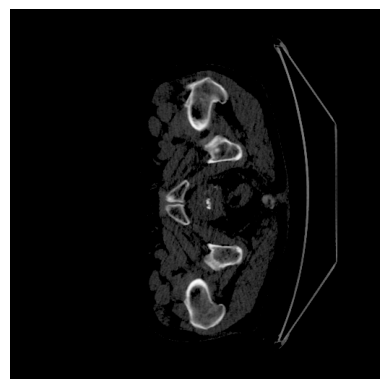

In [30]:
plt.imshow(img[:,:,79]**0.5,cmap='gray')
plt.axis('off')
fig=plt.gcf()
fig.savefig('C:/Users/oonar/Downloads/cls_fig_7_new.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.imshow(img[:,:,91],cmap='gray')

In [ ]:
imgi=np.ones((215,300))
imgi[60:215,0:240]=kuv1/np.max(kuv1)
for i in range(59):
    for j in range(240):
        imgi[i,j+60-i]=0
for i in range(2,155):
    for j in range(1,60):
        imgi[i+60-j,240+j]=0
plt.imshow(imgi,cmap='gray')